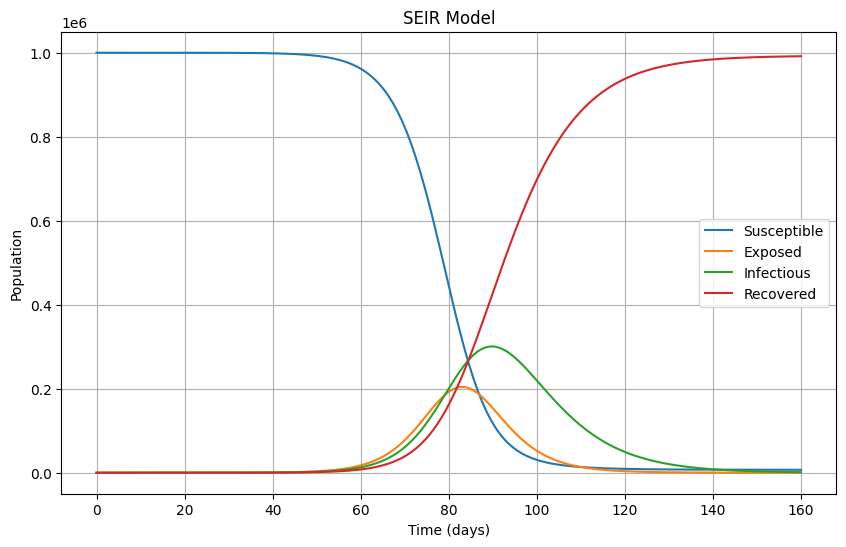

In [14]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the SEIR model
def seir_model(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# Initial conditions
N = 1_000_000  # Total population
I0 = 1         # Initial number of infected individuals
E0 = 0         # Initial number of exposed individuals
R0 = 0         # Initial number of recovered individuals
S0 = N - I0 - E0 - R0  # Initial number of susceptible individuals
y0 = S0, E0, I0, R0

# Parameters
beta = 0.5     # Transmission rate
sigma = 1/5.2  # Progression rate (incubation period ~5.2 days)
gamma = 1/10   # Recovery rate (infectious period ~10 days)

# Time grid (days)
t = np.linspace(0, 160, 160)

# Solve the differential equations
ret = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
S, E, I, R = ret.T

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, E, label='Exposed')
plt.plot(t, I, label='Infectious')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('SEIR Model')
plt.grid()
plt.show()



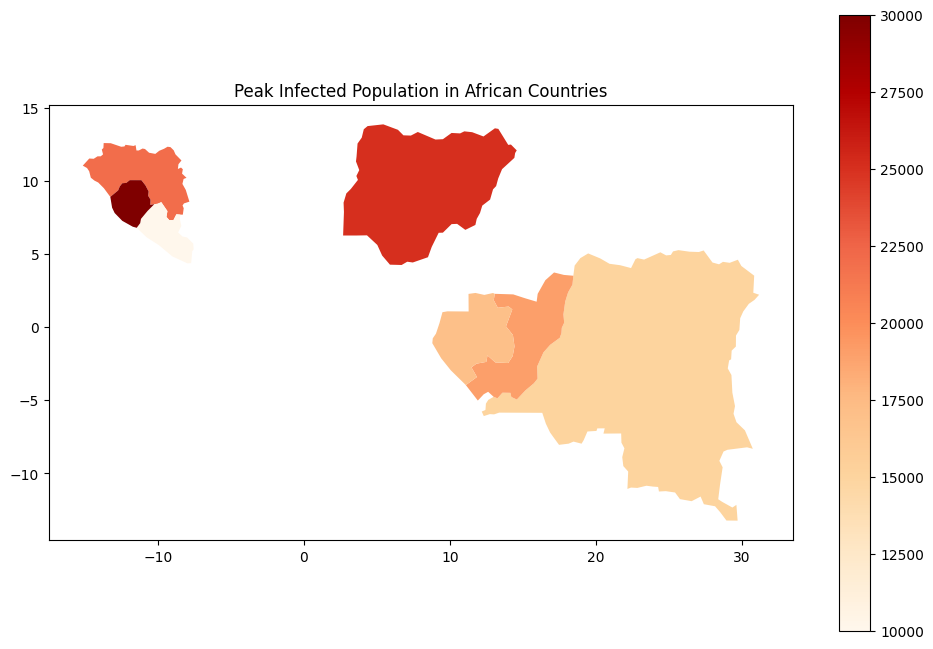

In [26]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile into a GeoDataFrame
world = gpd.read_file("/Users/JasonHunter/Desktop/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Load in the city data
cities = gpd.read_file("/Users/JasonHunter/Desktop/ne_110m_populated_places/ne_110m_populated_places.shp")
# print(cities.head())


# Filter out only African countries
africa = world[world['CONTINENT'] == 'Africa']
cities = cities[cities['ADM0NAME'].isin(africa['ADMIN'])]
# print(cities.head())

# Check the structure of the GeoDataFrame
# print(africa.head())

seir_results = pd.DataFrame({
    'ADMIN': ['Nigeria', 'Guinea', 'Sierra Leone', 'Liberia', 'Democratic Republic of the Congo', 'Gabon', 'Republic of the Congo'],  # Relevant countries
    'peak_infected': [25000, 22000, 30000, 10000, 15000, 17000, 19000],  # I added fake peak infected numbers for illustration
    # relevant cities
    
})

# Merge SEIR results with GeoDataFrame
africa = africa.merge(seir_results, on='ADMIN', how='left')


# Plot the map, coloring countries by peak infected
africa.plot(column='peak_infected', cmap='OrRd', legend=True, figsize=(12, 8))
plt.title('Peak Infected Population in African Countries')
plt.show()

In [27]:
africa_json = africa.to_crs(epsg=4326).to_json() # epsg=4326 is the WGS84 coordinate system


# create a folium map centered on Africa
m = folium.Map(location=[10, 20], zoom_start=3, tiles = 'cartodbpositron', min_zoom= 2, max_bounds=True)

# add the GeoDataFrame as a choropleth layer
folium.Choropleth(
    geo_data=africa_json,
    data=africa,
    columns=['ADMIN', 'peak_infected'],
    key_on='feature.properties.ADMIN',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Peak Infected Population'
).add_to(m)

# display the map
m.save("africa_seir_map.html")
m

In [ ]:
# file_path = '/Users/JasonHunter/Desktop/ebola-outbreaks-before-2014.xlsx'
# df = pd.read_excel(file_path)
# df.head(5)